只是一个toy model，用来说明量化回测框架支持神经网络的接入


In [8]:
import torch.nn as nn
import torch

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.2):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.bn(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import backtesting as bt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np

torch.manual_seed(888)
np.random.seed(888)

def create_dataset(stock_data, window_size):
    X = []
    y = []
    scaler = MinMaxScaler()
    stock_data_normalized = scaler.fit_transform(stock_data.values.reshape(-1, 1))

    for i in range(len(stock_data) - window_size - 2):
        X.append(stock_data_normalized[i:i + window_size])
        if stock_data.iloc[i + window_size + 2] > stock_data.iloc[i + window_size - 1]:
            y.append(1)
        else:
            y.append(0)

    X, y = np.array(X), np.array(y)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    return X, y, scaler

# 模型参数
input_size = 1
hidden_size = 64
num_layers = 2
num_classes = 2
window_size = 10

data = pd.read_csv('stock/day/000012.XSHE.csv')
X, y, scaler = create_dataset(data['close'], window_size)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 创建 DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

model = SimpleLSTM(input_size, hidden_size, num_layers, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200

# 训练模型
for epoch in range(num_epochs):
    for i, (batch_X, batch_y) in enumerate(train_loader):
         # 前向传播
         outputs = model(batch_X)
         loss = criterion(outputs, batch_y)
         # 反向传播和优化
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Finished Training')
torch.save(model.state_dict(), 'rnn_model.pth')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    for batch_X, batch_y in test_loader:
          outputs = model(batch_X)
          _, predicted = torch.max(outputs.data, 1)
          total += batch_y.size(0)
          correct += (predicted == batch_y).sum().item()

print(f'Accuracy of the model on the test data: {100 * correct / total}%')

Epoch [10/200], Loss: 0.6959
Epoch [20/200], Loss: 0.7102
Epoch [30/200], Loss: 0.6823
Epoch [40/200], Loss: 0.6923
Epoch [50/200], Loss: 0.6872
Epoch [60/200], Loss: 0.6890
Epoch [70/200], Loss: 0.6973
Epoch [80/200], Loss: 0.7051
Epoch [90/200], Loss: 0.6854
Epoch [100/200], Loss: 0.6958
Epoch [110/200], Loss: 0.6946
Epoch [120/200], Loss: 0.6828
Epoch [130/200], Loss: 0.6927
Epoch [140/200], Loss: 0.6958
Epoch [150/200], Loss: 0.6935
Epoch [160/200], Loss: 0.6975
Epoch [170/200], Loss: 0.6898
Epoch [180/200], Loss: 0.6917
Epoch [190/200], Loss: 0.6964
Epoch [200/200], Loss: 0.6946
Finished Training
Accuracy of the model on the test data: 50.0%


Starting Portfolio Value: 10000.00
2005-01-18,  BUY : data_name:000012.XSHE price : 33.74 , cost : 3374.0 , commission : 1.6870000000000003
2005-01-18, open symbol is : 000012.XSHE , price : 33.74 
Final Portfolio Value: 26096.31


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is depre

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,64.09,2010-11-24,2018-10-17,NaT,NaN
1,63.02,2007-09-18,2008-11-03,2010-09-13,780
3,21.46,2006-05-31,2006-08-03,2006-12-22,148
2,19.59,2007-04-25,2007-06-01,2007-08-02,72
4,14.01,2007-01-23,2007-02-01,2007-04-05,53


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:red'` for same effect.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

Stress Events,mean,min,max
Lehman,-0.68%,-5.30%,5.62%
US downgrade/European Debt Crisis,-0.44%,-6.13%,3.02%
Fukushima,-0.60%,-3.62%,2.19%
EZB IR Event,-0.14%,-3.65%,2.85%
Aug07,0.84%,-3.66%,7.44%
Mar08,-1.08%,-7.36%,6.18%
Sept08,-0.44%,-5.30%,5.62%
2009Q1,0.40%,-6.56%,6.45%
2009Q2,0.65%,-6.87%,7.12%
Flash Crash,-1.02%,-4.50%,0.85%


Top 10 long positions of all time,max
000012.XSHE,86.78%


Top 10 short positions of all time,max


Top 10 positions of all time,max
000012.XSHE,86.78%


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:1546: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(turnover, ax=ax, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:1626: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  txn_time = txn_time.groupby(level=0).sum().reindex(index=range(570, 961))


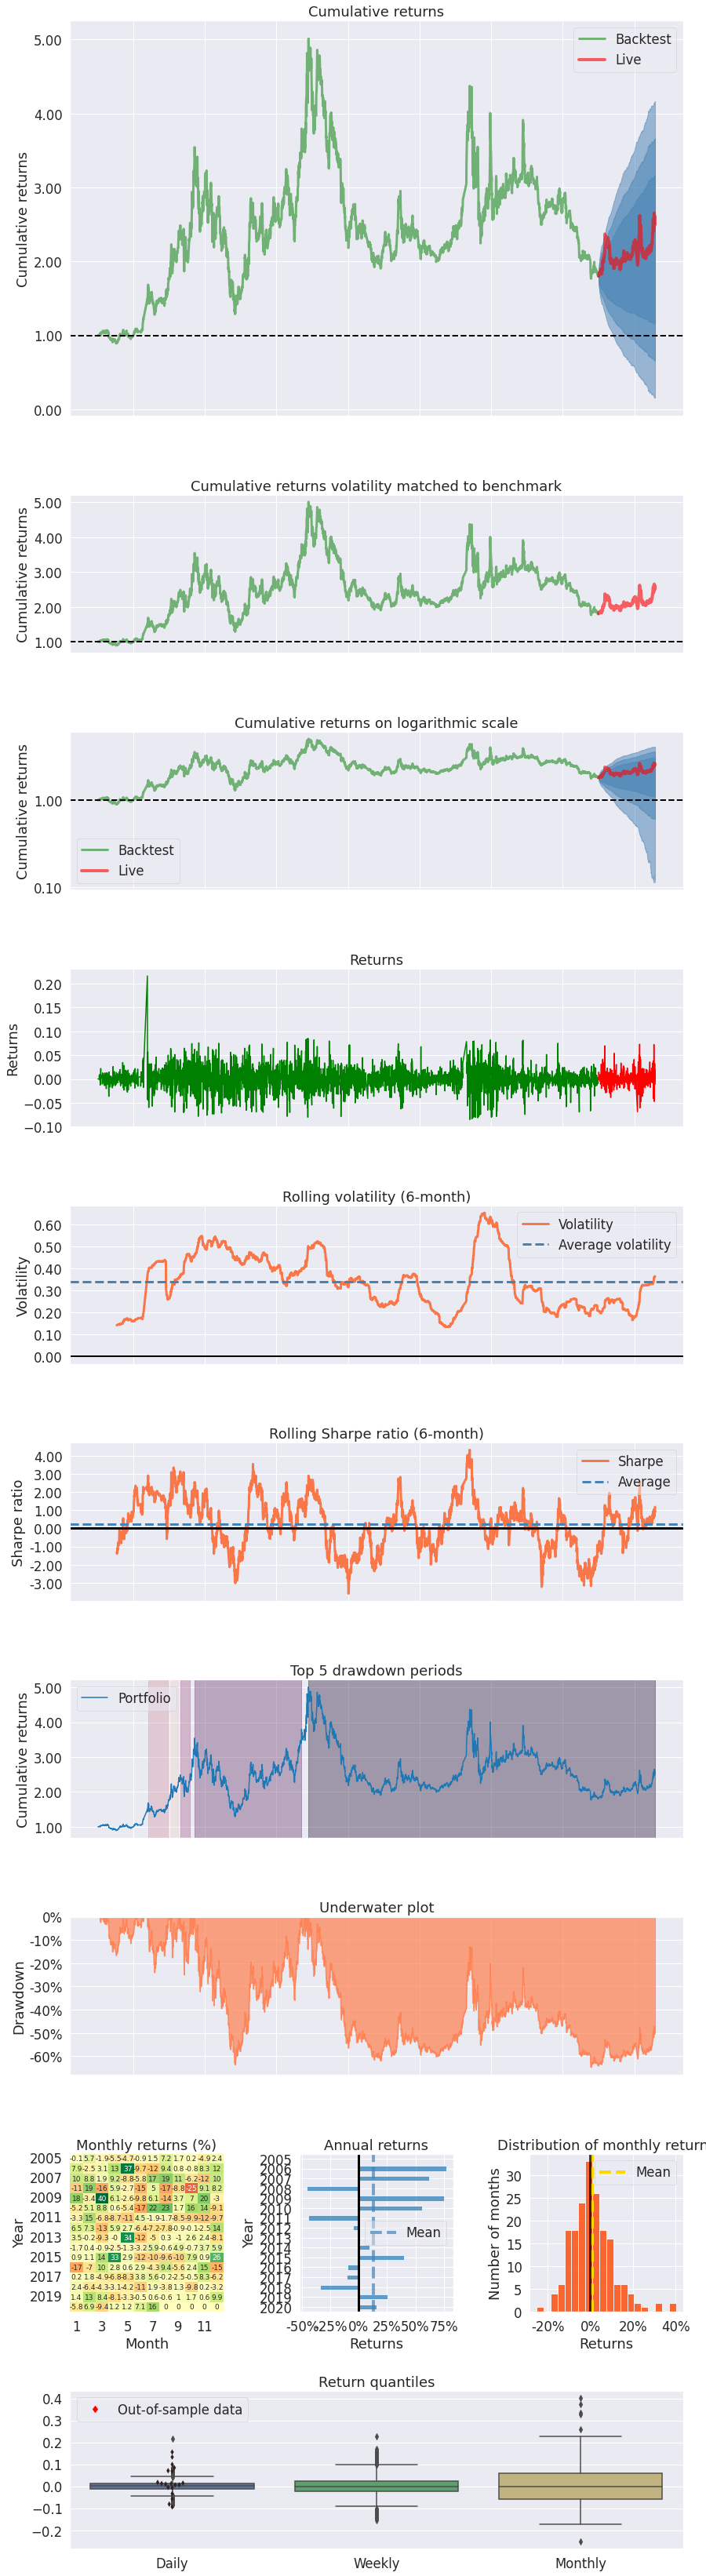

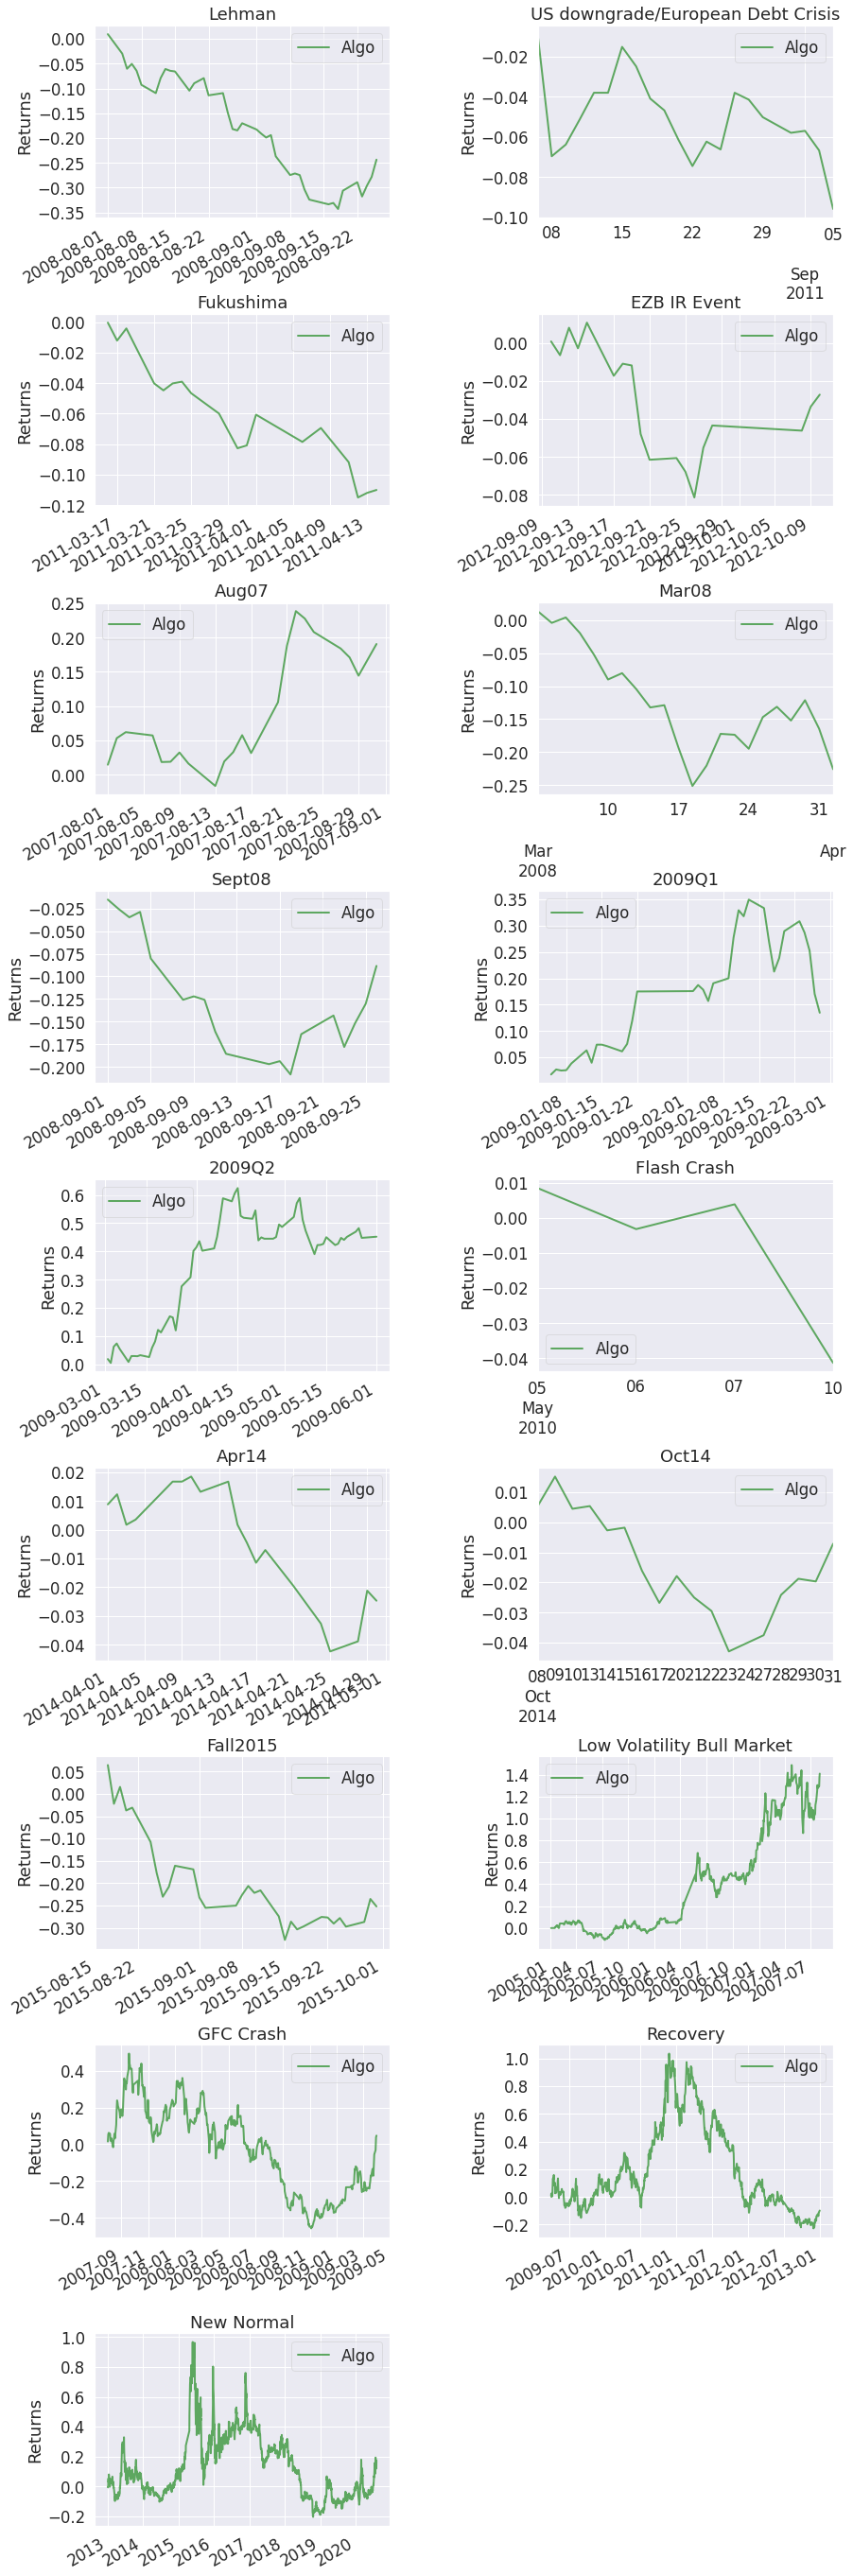

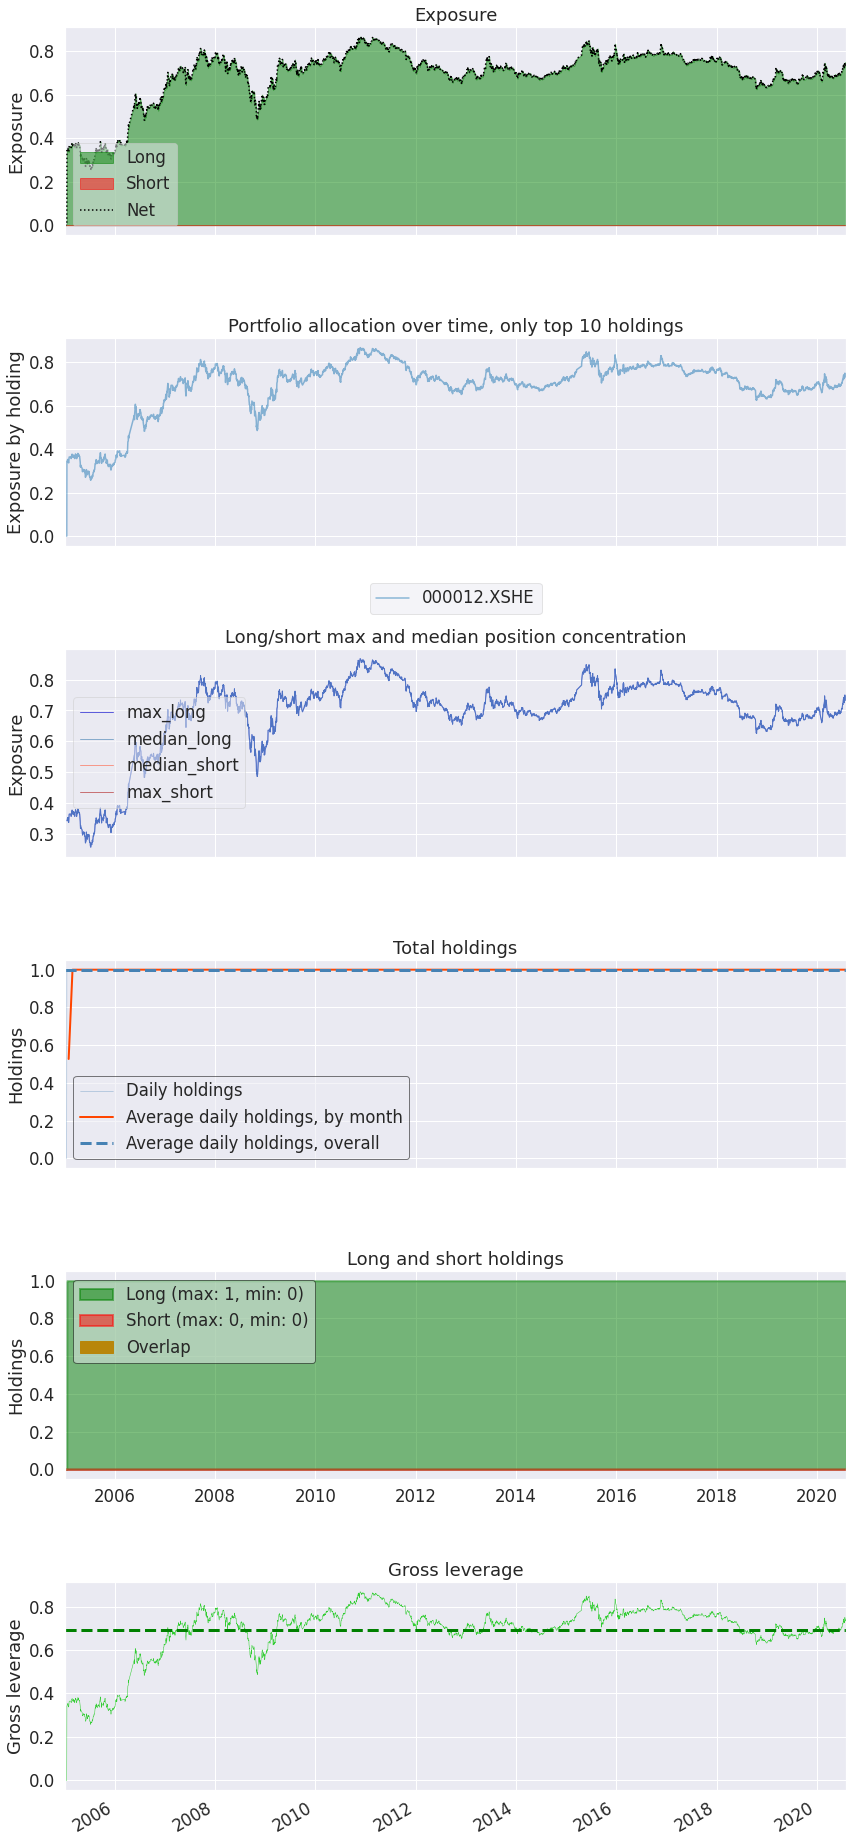

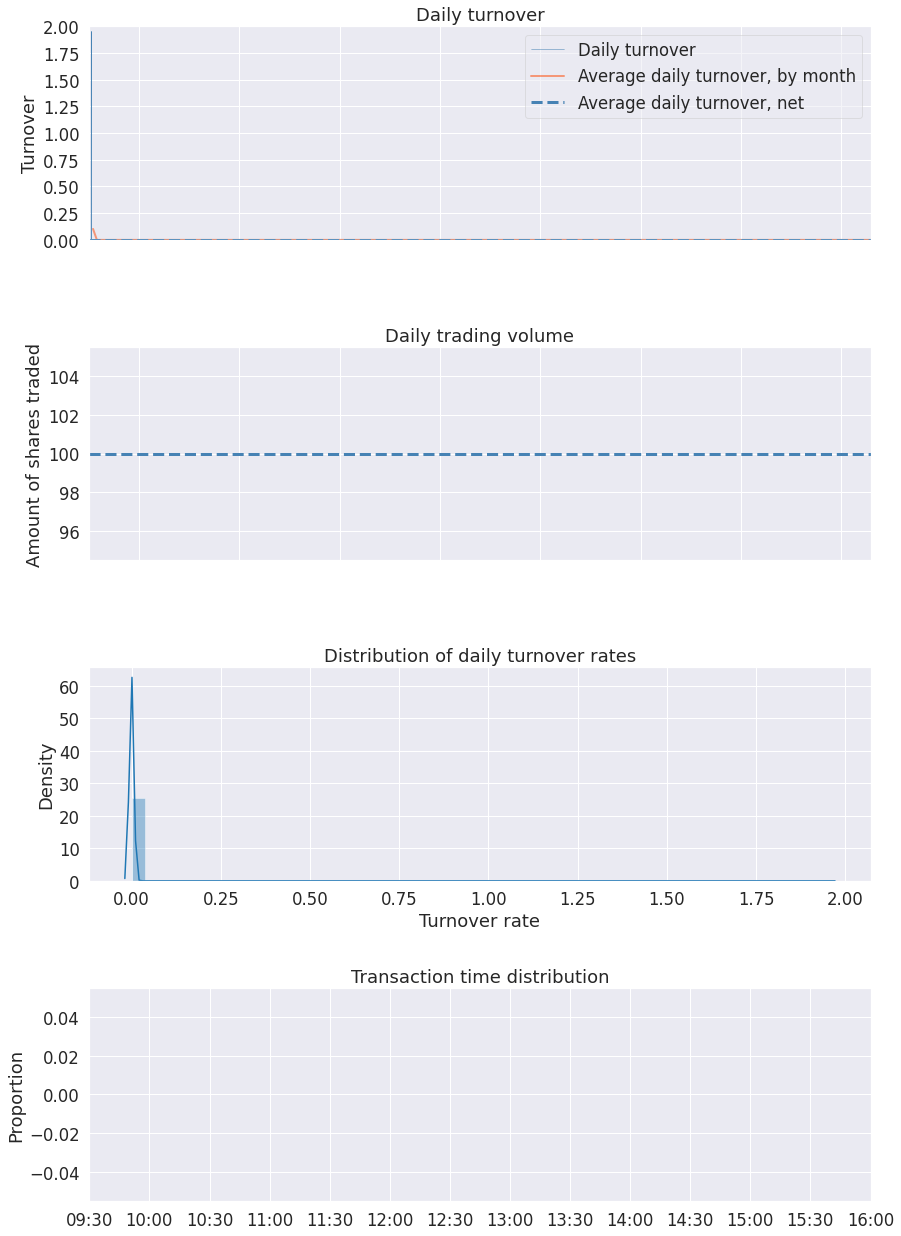

In [11]:
import pyfolio as pf
import datetime
# 构建策略
class LSTMStrategy(bt.Strategy):
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    def __init__(self):
        self.data_close = self.datas[0].close
        self.model = SimpleLSTM(input_size, hidden_size, num_layers, num_classes)
        self.model.load_state_dict(torch.load('rnn_model.pth'))
        self.model.eval()
        self.scaler = scaler
        self.counter = 1

    def next(self):
        if self.counter < window_size:
            self.counter += 1
            return
        previous_close_prices = [self.data_close[-i] for i in range(0, window_size)]
        X = torch.tensor(previous_close_prices).view(1, window_size, -1).float()
        X = self.scaler.transform(X.numpy().reshape(-1, 1)).reshape(1, window_size, -1)

        prediction = self.model(torch.tensor(X).float())
        max_vals, max_idxs = torch.max(prediction, dim=1)
        predicted_prob, predicted_trend = max_vals.item(), max_idxs.item()

        if predicted_trend == 1 and not self.position:  # 上涨趋势
            self.order = self.buy() # 买入股票
        elif predicted_trend == 0 and self.position:  # 如果预测不是上涨趋势且持有股票，卖出股票
            self.order = self.sell()
    
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status == order.Rejected:
            self.log(f"Rejected : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Margin:
            self.log(f"Margin : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Cancelled:
            self.log(f"Concelled : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Partial:
            self.log(f"Partial : order_ref:{order.ref}  data_name:{order.p.data._name}")
         
        if order.status == order.Completed:
            if order.isbuy():
                self.log(f" BUY : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

            else:  # Sell
                self.log(f" SELL : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")
    
    def notify_trade(self, trade):
        # 一个trade结束的时候输出信息
        if trade.isclosed:
            self.log('closed symbol is : {} , total_profit : {} , net_profit : {}' .format(
                            trade.getdataname(),trade.pnl, trade.pnlcomm))
            # self.trade_list.append([self.datas[0].datetime.date(0),trade.getdataname(),trade.pnl,trade.pnlcomm])
            
        if trade.isopen:
            self.log('open symbol is : {} , price : {} ' .format(
                            trade.getdataname(),trade.price))
    def stop(self):
        
        pass 


# Load test data
test_data = pd.read_csv('./stock/day/000012.XSHE.csv', index_col=0, parse_dates=True)

# Create a cerebro entity
cerebro = bt.Cerebro(runonce=False)
params=dict(
    
    fromdate = datetime.datetime(2005,1,4),
    todate = datetime.datetime(2020,7,31),
    timeframe = bt.TimeFrame.Days,
    dtformat = ("%Y-%m-%d"),
    # compression = 1,
    datetime = 0,
    open = 1,
    high = 2,
    low =3,
    close =4,
    volume =5,
    openinterest=-1)
# Add data to cerebro
df = pd.read_csv("./stock/day/000012.XSHE.csv")
df.columns = ['datetime','open','high','low','close','volume','openinterest']
df.index = pd.to_datetime(df['datetime'])
df = df[['open','high','low','close','volume','openinterest']]
df = df[(df.index<=params['todate'])&(df.index>=params['fromdate'])]
feed = bt.feeds.PandasDirectData(dataname = df)
# 添加数据到cerebro
cerebro.adddata(feed, name = "000012.XSHE")

# Add strategy to cerebro
cerebro.addstrategy(LSTMStrategy)
cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
cerebro.addanalyzer(bt.analyzers.PyFolio)

# 本金10000，每次交易100股
cerebro.broker.setcash(10000)
cerebro.addsizer(bt.sizers.FixedSize, stake=100)

# 万五佣金
cerebro.broker.setcommission(commission=0.0005)


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
results=cerebro.run()


# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# 打印相关信息
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2019-01-01',
    )